<a href="https://colab.research.google.com/github/harryypham/MyMLPractice/blob/main/practice/resnext_flower17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import tarfile
import urllib

In [ ]:
def jpg_files(members):
    for tarinfo in members:
        if os.path.splitext(tarinfo.name)[1] == ".jpg":
            yield tarinfo

def untar(fname,path="17category-flowers-py"): #untarring the archive
    tar = tarfile.open(fname)
    tar.extractall(path=path, members=jpg_files(tar))
    tar.close()
    if path == "":
        print("File Extracted in Current Directory")
    else:
        print("File Extracted in to",  path)


def download(filename, source_url, work_directory):
    if not os.path.exists(work_directory): #check if the folder exists; if not make dir
        os.mkdir(work_directory)
    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath): # check if file exists; if not, download
        print("Downloading file, Please wait...")
        filepath, _ = urllib.request.urlretrieve(source_url + filename, # this is a function to download files
                                                 filepath)
        statinfo = os.stat(filepath)
        print(('Succesfully downloaded', filename, statinfo.st_size, 'bytes.'))
        untar(filepath,work_directory)
    return filepath

In [ ]:
download("17flowers.tgz", "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/","data")

('Succesfully downloaded', '17flowers.tgz', 60270631, 'bytes.')
File Extracted in to data


'data/17flowers.tgz'

In [ ]:
j=1
train_dir = "/content/data/train/"
test_dir = "/content/data/test/"
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
os.mkdir(train_dir + f"{j}/")
os.mkdir(test_dir + f"{j}/")
for i in range(1, 1361):
    fname="/content/data/jpg/"
    fpath = os.path.join(fname + "image_" + str(i).zfill(4) + ".jpg")
    idx = i % 80 if i % 80 != 0 else 80
    if idx <= 70:
      shutil.move(fpath, f"/content/data/train/{j}/{idx}.jpg")
    else:
      shutil.move(fpath, f"/content/data/test/{j}/{idx}.jpg")
    if i%80==0 and j != 17:
      j+=1
      os.mkdir(train_dir + f"{j}/")
      os.mkdir(test_dir + f"{j}/")

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [ ]:
def get_mean_and_std(dataset, num_channels):
    """
    Calculate the mean and std of a dataset
    """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for inputs, labels in dataloader:
      for channel in range(num_channels):
        mean[channel] += inputs[:,channel,:,:].mean()
        std[channel] += inputs[:,channel,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4264, 0.4253, 0.2804), (0.2451, 0.2236, 0.2038))
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4264, 0.4253, 0.2804), (0.2451, 0.2236, 0.2038))
])
batch_size = 16


trainset = torchvision.datasets.ImageFolder(root='/content/data/train', transform=train_transform)
testset = torchvision.datasets.ImageFolder(root='/content/data/test', transform=test_transform)


trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=2)

torch.Size([8])


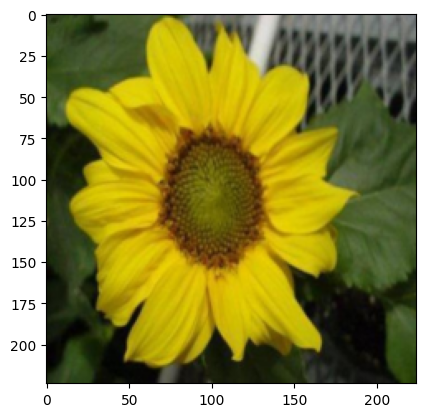

In [ ]:
def imshow(img):
    plt.imshow(np.transpose(img[0].numpy(), (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(images)
print(labels.shape)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class Block(nn.Module):
    '''Grouped convolution block.'''
    expansion = 2

    def __init__(self, in_planes, cardinality=32, bottleneck_width=4, stride=1):
        super(Block, self).__init__()
        group_width = cardinality * bottleneck_width
        self.conv1 = nn.Conv2d(in_planes, group_width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(group_width)
        self.conv2 = nn.Conv2d(group_width, group_width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(group_width)
        self.conv3 = nn.Conv2d(group_width, self.expansion*group_width, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*group_width)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*group_width:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*group_width, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*group_width)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNeXt(nn.Module):
    def __init__(self, num_blocks, cardinality, bottleneck_width, num_classes=10):
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)
        self.layer1 = self._make_layer(num_blocks[0], 1)
        self.layer2 = self._make_layer(num_blocks[1], 2)
        self.layer3 = self._make_layer(num_blocks[2], 2)
        self.layer4 = self._make_layer(num_blocks[3], 2)
        self.linear = nn.Linear(2048, 17)

    def _make_layer(self, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(Block(self.in_planes, self.cardinality, self.bottleneck_width, stride))
            self.in_planes = Block.expansion * self.cardinality * self.bottleneck_width
        # Increase bottleneck_width by 2 after each stage.
        self.bottleneck_width *= 2
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.pool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 7)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNeXt50_32x4d():
    return ResNeXt(num_blocks=[3,4,6,3], cardinality=32, bottleneck_width=4)

In [ ]:
model = ResNeXt50_32x4d()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_epochs = 20
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}:')
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        model.train()
        inputs, targets = inputs.to(device), targets.to(device)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
          train_loss += loss.item()

          if (not batch_idx % 10) and batch_idx != 0:
                print ('Batch %03d | Cost: %.6f'
                      %(batch_idx, train_loss/(batch_idx+1)))


Epoch 1:
Batch 010 | Cost: 3.571341
Batch 020 | Cost: 3.304067
Batch 030 | Cost: 3.116060
Batch 040 | Cost: 3.024423
Batch 050 | Cost: 2.921861
Batch 060 | Cost: 2.859209
Batch 070 | Cost: 2.778746

Epoch 2:
Batch 010 | Cost: 2.220362
Batch 020 | Cost: 2.146380
Batch 030 | Cost: 2.109079
Batch 040 | Cost: 2.111855
Batch 050 | Cost: 2.117971
Batch 060 | Cost: 2.121807
Batch 070 | Cost: 2.136161

Epoch 3:
Batch 010 | Cost: 1.583796
Batch 020 | Cost: 1.539549
Batch 030 | Cost: 1.548763
Batch 040 | Cost: 1.636065
Batch 050 | Cost: 1.647867
Batch 060 | Cost: 1.654728
Batch 070 | Cost: 1.649488

Epoch 4:
Batch 010 | Cost: 1.369896
Batch 020 | Cost: 1.311239
Batch 030 | Cost: 1.377494
Batch 040 | Cost: 1.360239
Batch 050 | Cost: 1.341961
Batch 060 | Cost: 1.343785
Batch 070 | Cost: 1.358997

Epoch 5:
Batch 010 | Cost: 1.368409
Batch 020 | Cost: 1.377443
Batch 030 | Cost: 1.305711
Batch 040 | Cost: 1.269815
Batch 050 | Cost: 1.267003
Batch 060 | Cost: 1.252079
Batch 070 | Cost: 1.263290

Epoc

In [ ]:
def compute_accuracy(dataloader, model, device):
  model.to(device)
  model.eval()
  with torch.set_grad_enabled(False):
    correct = 0
    total = 0
    for inputs, targets in dataloader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = model(inputs)
      _, predict = torch.max(outputs, 1)
      correct += predict.eq(targets).sum().item()
      total += targets.shape[0]

    return correct/total * 100

print(compute_accuracy(testloader, pretrained_model, device))

7.0588235294117645


In [ ]:
del model

In [ ]:
pretrained_model = torchvision.models.resnext50_32x4d(weights="DEFAULT")
pretrained_model.fc = nn.Linear(2048, 17)
ct = 0
for child in pretrained_model.children():
  ct += 1
  print(ct, child)
  if ct <= 9:
      for param in child.parameters():
          param.requires_grad = False

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_epochs = 20
pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=5e-4, weight_decay=1e-4)

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}:')
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        pretrained_model.train()
        inputs, targets = inputs.to(device), targets.to(device)
        pretrained_model.zero_grad()
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
          train_loss += loss.item()

          if (not batch_idx % 10) and batch_idx != 0:
                print ('Batch %03d | Cost: %.6f'
                      %(batch_idx, train_loss/(batch_idx+1)))